# EJERCICIO CLASE FINAL GRUPO 4

## INTEGRANTES:
- Carlos Chicaiza
- Emilio Mayorga
- Jessica Llumiguano
- Juan Vizuete

Se obtuvo los datos de un libro de Kaggle: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset/data

Este conjunto de datos permite detectar intrusiones cibernéticas a partir del tráfico de red y el comportamiento del usuario. Contiene características clave para identificar amenazas y se puede utilizar en modelos de aprendizaje automático.

## Levantamiento de proyecto

Para iniciar con el levantamiento del proyecto, se tiene que primero instalar la libreria que permite conectarse entre python y postgresql que será la base de datos con la que trabajaremos.

In [10]:
%pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


A continuación, se importan las librerías necesarias para el análisis de datos, visualización y conexión con la base de datos:  

- **pandas (`pd`)**: Con esta vamos a manejar y análisar los datos con un dataframe.  
- **numpy (`np`)**: No ayudara con el soporte para operaciones numéricas y trabajar con matrices.  
- **matplotlib.pyplot (`plt`)**: La usaremos par crear gráficos y visualizar datos.  
- **seaborn (`sns`)**: Esta libreria la usaremos con matplotlib para datos avanzados.  
- **psycopg2**: Con esta libreria podremos conectarnos y ejecutar consiltas en postgresql.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# base de datos
import psycopg2

### Carga del Conjunto de Datos  

Usamos `pandas` para cargar el archivo CSV en un **DataFrame**, lo que nos permite manipular y analizar los datos de manera eficiente.  

- `pd.read_csv(...)`: Carga el archivo CSV en un DataFrame de pandas.  
- `df`: Variable que almacena el DataFrame resultante.
- Despues de eso inspeccionamos los datos usando  `df.columns` para validar la cabecera, `df.shape` para conocer el tamaño del dataframe, y finalmente el `df.dtypes` para conocer los tipos de datos de cada columna.

In [12]:
df = pd.read_csv('./data/cybersecurity_intrusion_data.csv')

In [16]:
print(list(df.columns))

['session_id', 'network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access', 'attack_detected']


In [14]:
print(df.shape)

(9537, 11)


In [15]:
print(df.dtypes)

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object


### Creación de la Base de Datos en PostgreSQL  

Antes de iniciar con la creación de la base de datos, primero creamos variables finales, que no permitiran conoer los datos de conexión con el servidor postgres y la base de datos.

In [17]:
DB_CONFIG = {
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": "5432",
}
DATABASE_NAME = "cybersecurity_intrusion"
TABLE_NAME = "intrusion_log"

Establecemos conexión con el servidor PostgreSQL y verificamos si la base de datos **`cybersecurity_intrusion`** ya existe.  

- Se conecta al servidor con las credenciales (`user`, `password`, `host`, `port`).  
- Se habilita `autocommit` para ejecutar comandos sin necesidad de confirmar manualmente.  
- Se crea un **cursor** para ejecutar consultas SQL.  
- Se ejecuta una consulta para verificar si la base de datos ya existe en `pg_database`.  
  - Si **no existe**, se ejecuta el comando `CREATE DATABASE cybersecurity_intrusion;`.  
  - Si **ya existe**, se imprime `"Ya existe la base de datos"`.  
- Finalmente, se cierra el cursor y la conexión al servidor.  
- Si ocurre algún error en la conexión o creación de la base, se captura y muestra un mensaje con `except Exception as e`.  

In [18]:
try:
    connection = psycopg2.connect(**DB_CONFIG)
    connection.autocommit = True
    cursor = connection.cursor()
    cursor.execute(f"SELECT datname FROM pg_database WHERE datname='{DATABASE_NAME}';")
    if not cursor.fetchone():
        cursor.execute(f"CREATE DATABASE {DATABASE_NAME};")
        print("Base de datos creada exitosamente")
    else:
        print("Ya existe la base de datos")
    
    cursor.close()
    connection.close()
        
except Exception as e:
        print(f"Error al crear la base de datos: {e}")

Ya existe la base de datos


### Creación de la Tabla en PostgreSQL  

- La consulta SQL crea una tabla llamada `intrusion_logs` si no existe, con las siguientes columnas:  
  - `id`: Identificador único (clave primaria).  
  - `network_packet_size`: Tamaño del paquete de red (entero).  
  - `protocol_type`: Tipo de protocolo de comunicación (cadena de texto).  
  - `login_attempts`: Número de intentos de inicio de sesión (entero).  
  - `session_duration`: Duración de la sesión en segundos (precisión doble).  
  - `encryption_used`: Tipo de cifrado utilizado (cadena de texto).  
  - `ip_reputation_score`: Puntuación de reputación de la IP (precisión doble).  
  - `failed_logins`: Número de intentos de inicio de sesión fallidos (entero).  
  - `browser_type`: Tipo de navegador (cadena de texto).  
  - `unusual_time_access`: Indicador binario de acceso en un momento inusual (entero).  
  - `attack_detected`: Indicador binario de si se detectó un ataque (entero).  


In [35]:
try:
    connection = psycopg2.connect(database=DATABASE_NAME, **DB_CONFIG)
    cursor = connection.cursor()
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {TABLE_NAME}(
            id SERIAL PRIMARY KEY,
            network_packet_size int,
            protocol_type varchar(5),
            login_attempts int,
            session_duration double precision,
            encryption_used varchar(5),
            ip_reputation_score double precision,
            failed_logins int,
            browser_type varchar(10),
            unusual_time_access int,
            attack_detected int
        );
    """)
    print(f"Tabla {TABLE_NAME} añadida exitosamente")
    
    connection.commit()

    cursor.close()
    connection.close()
        
except Exception as e:
        print(f"Error al crear la tabla: {e}")

Tabla intrusion_log añadida exitosamente


## Preprocesamiento

Este fragmento de código usamos para verificar si existen valores nulos (ausentes) en las columnas del DataFrame **`df`**.

In [22]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


Este bloque de código normaliza las columnas de texto del DataFrame **`df`** convirtiendo todas las cadenas a minúsculas.

In [23]:
df_normalized = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
print(df_normalized[:5])

  session_id  network_packet_size protocol_type  login_attempts  \
0  sid_00001                  599           tcp               4   
1  sid_00002                  472           tcp               3   
2  sid_00003                  629           tcp               3   
3  sid_00004                  804           udp               4   
4  sid_00005                  453           tcp               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             des             0.606818              1   
1       1557.996461             des             0.301569              0   
2         75.044262             des             0.739164              2   
3        601.248835             des             0.123267              0   
4        532.540888             aes             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         edge                    0                1  
1      firefox                    0 

Este bloque de código reemplaza los valores "unknown" y `None` que se encuentran en **`df_normalized`** con **`NaN`**, que es el valor estándar para representar valores nulos en pandas. 

In [24]:
df_normalized.replace(['unknown', None], np.nan, inplace=True)
print(df_normalized[10:20])

   session_id  network_packet_size protocol_type  login_attempts  \
10  sid_00011                  407           udp               6   
11  sid_00012                  406           udp               9   
12  sid_00013                  548           tcp               2   
13  sid_00014                  117           tcp               4   
14  sid_00015                  155           tcp               3   
15  sid_00016                  387          icmp               6   
16  sid_00017                  297           tcp               8   
17  sid_00018                  562           udp               1   
18  sid_00019                  318           tcp               5   
19  sid_00020                  217          icmp               2   

    session_duration encryption_used  ip_reputation_score  failed_logins  \
10        580.721925             des             0.122894              3   
11        191.052837             des             0.339711              1   
12        186.147638   

Elimina todas las filas que contienen valores `NaN`. El parámetro **`inplace=True`** asegura que los cambios se realicen directamente en el DataFrame sin necesidad de crear una copia.

In [25]:
df_normalized.dropna(inplace=True)

Elimina las filas duplicadas, dejando solo una instancia de cada fila. Al igual que con la eliminación de valores nulos, **`inplace=True`** asegura que se realicen los cambios directamente en el DataFrame.

In [30]:
df_normalized.drop_duplicates(inplace=True)

Elimina la columna **`session_id`** y especificamos el **`axis=1`** para que la eliminación se realice a lo largo de la columna.

In [32]:
df_normalized.drop(['session_id'], axis=1, inplace=True)

In [37]:
print(df_normalized[0:10])

    network_packet_size protocol_type  login_attempts  session_duration  \
0                   599           tcp               4        492.983263   
1                   472           tcp               3       1557.996461   
2                   629           tcp               3         75.044262   
4                   453           tcp               5        532.540888   
5                   453           udp               5        380.471550   
6                   815          icmp               4        728.107165   
7                   653           tcp               3         12.599906   
10                  407           udp               6        580.721925   
11                  406           udp               9        191.052837   
15                  387          icmp               6        292.136196   

   encryption_used  ip_reputation_score  failed_logins browser_type  \
0              des             0.606818              1         edge   
1              des             0

Se ha limpiado la tabla.

### Inserción de Datos en la Base de Datos

Este bloque de código inserta datos desde **`df_normalized`** en la tabla **`intrusion_log`**.

In [41]:
try:
    connection = psycopg2.connect(database=DATABASE_NAME, **DB_CONFIG)
    cursor = connection.cursor()
    
    logs = df_normalized[0:10]

    data_to_insert = [
        tuple(
            int(x) if isinstance(x, np.int64) else 
            float(x) if isinstance(x, np.float64) else x 
            for x in row
        )
        for row in logs[list(df_normalized.columns)].to_records(index=False)
    ]
    
    cursor.executemany("""
        INSERT INTO intrusion_log (
            network_packet_size,protocol_type,login_attempts,session_duration,
            encryption_used,ip_reputation_score,failed_logins,browser_type,
            unusual_time_access,attack_detected
        )
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """,data_to_insert)

    connection.commit()
    print("Se han agregado los logs")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")
    

Se han agregado los logs


### Consulta e Impresión de Registros

Este bloque de código realiza una consulta a la tabla **`intrusion_log`** en la base de datos e imprime los primeros 10 registros obtenidos.

In [42]:
try:
    connection = psycopg2.connect(database=DATABASE_NAME, **DB_CONFIG)
    cursor = connection.cursor()
    
    cursor.execute("SELECT * FROM intrusion_log LIMIT 10;")
    result = cursor.fetchall()
    
    for i in result:
        print(i)

    print("Se ha realizado la impresion")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")

(1, 599, 'tcp', 4, 492.9832634426563, 'des', 0.606818080396889, 1, 'edge', 0, 1)
(2, 472, 'tcp', 3, 1557.9964611204384, 'des', 0.3015689675960893, 0, 'firefox', 0, 0)
(3, 629, 'tcp', 3, 75.04426166420741, 'des', 0.7391643279163831, 2, 'chrome', 0, 1)
(4, 453, 'tcp', 5, 532.5408884201419, 'aes', 0.0548738567431703, 1, 'firefox', 0, 0)
(5, 453, 'udp', 5, 380.4715502453134, 'aes', 0.4224858607066699, 2, 'chrome', 1, 0)
(6, 815, 'icmp', 4, 728.1071646972356, 'aes', 0.4137719285892984, 1, 'chrome', 0, 1)
(7, 653, 'tcp', 3, 12.5999060098958, 'des', 0.0977193658576949, 3, 'chrome', 1, 1)
(8, 407, 'udp', 6, 580.7219253670751, 'des', 0.1228937389064628, 3, 'firefox', 0, 1)
(9, 406, 'udp', 9, 191.0528369326706, 'des', 0.3397112713433893, 1, 'edge', 0, 1)
(10, 387, 'icmp', 6, 292.1361960073892, 'des', 0.2549124511362793, 3, 'chrome', 0, 1)
Se ha realizado la impresion


## Gráficos

### Distribución de Ataques por Navegador

En este bloque de código se realiza el filtrado de los ataques detectados y luego se crea un gráfico de pastel que muestra la distribución de estos ataques por tipo de navegador.


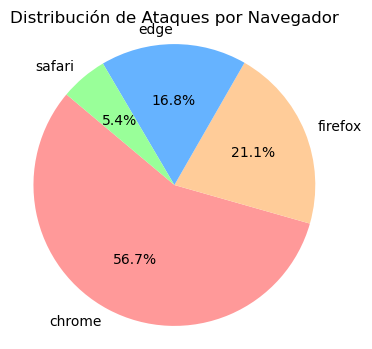

In [103]:
# Filtrar solo los ataques detectados (attack_detected == 1)
df_attacks = df_normalized[df_normalized['attack_detected'] == 1]

# Contar los ataques por tipo de navegador
attack_counts = df_attacks['browser_type'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(4, 4))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=['#ff9999','#ffcc99', '#66b3ff','#99ff99'])
plt.title('Distribución de Ataques por Navegador')
plt.axis('equal')  # Para hacer el gráfico circular

# Mostrar el gráfico
plt.savefig('img/distribution_attack_navegator.png')

### Distribución de Protocolos y Ataques Detectados

En este bloque de código, se agrupan los datos por tipo de protocolo y si se detectó un ataque. Posteriormente, se crea un gráfico de barras para visualizar cuántos ataques han sido detectados para cada tipo de protocolo.


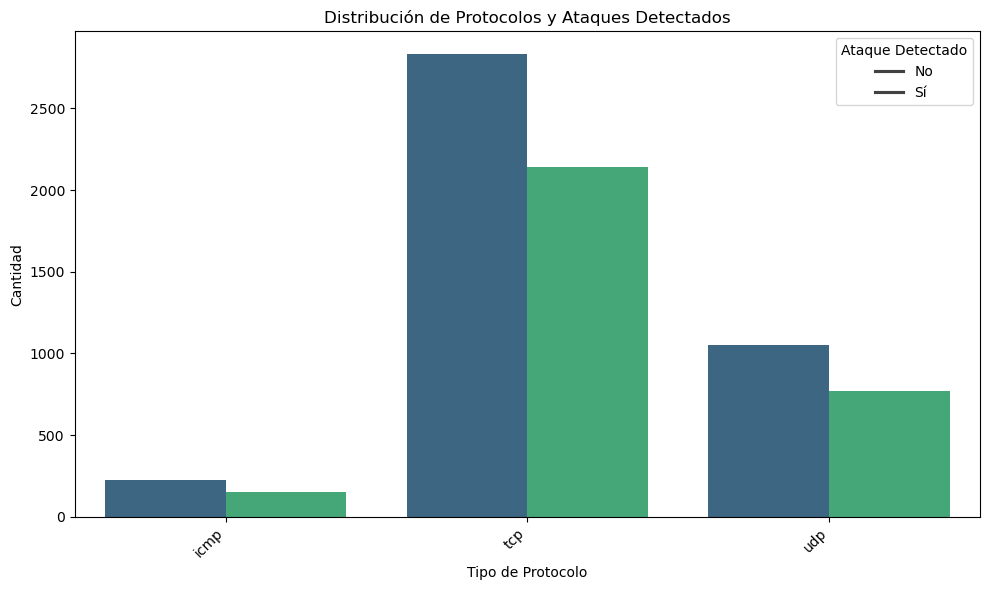

In [7]:
# Agrupar los datos por tipo de protocolo y ataque detectado
grouped_data = df_normalized.groupby(['protocol_type', 'attack_detected']).size().reset_index(name='count')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='protocol_type', y='count', hue='attack_detected', palette='viridis')

# Configurar el gráfico
plt.title('Distribución de Protocolos y Ataques Detectados')
plt.xlabel('Tipo de Protocolo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ataque Detectado', labels=['No', 'Sí'])
plt.tight_layout()
plt.savefig('img/protocool_type_attack.png')

### Gráfico de Dispersión de Duración de Sesión vs. Reputación de IP por Tipo de Protocolo

In [24]:
df_normal_pic = df_normalized.copy() 
df_normal_pic['session_duration'] = df_normal_pic['session_duration'] / 60

Este bloque de código tiene como objetivo visualizar la relación entre la **duración de sesión** (convertida a minutos) y la **reputación de IP**, separando los puntos por el tipo de protocolo, usando un gráfico de dispersión (scatterplot).


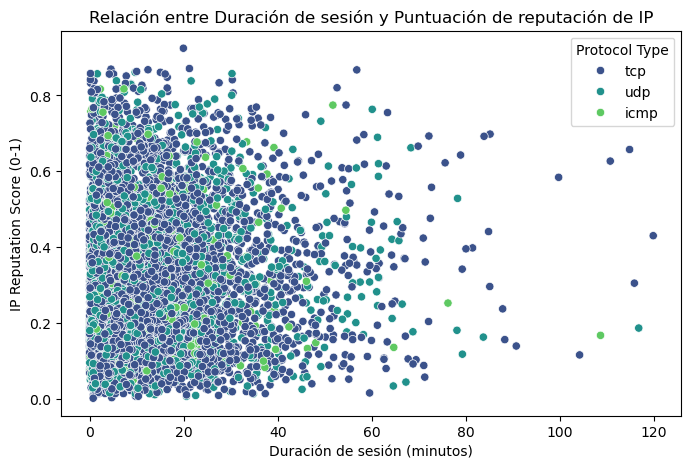

In [102]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_normal_pic, x="session_duration", y="ip_reputation_score", hue="protocol_type", palette="viridis")
plt.title("Relación entre Duración de sesión y Puntuación de reputación de IP")
plt.xlabel("Duración de sesión (minutos)")
plt.ylabel("IP Reputation Score (0-1)")
plt.legend(title="Protocol Type")
plt.savefig('img/duration_score_ip_protocol.png')

### Gráfico de Barras Apiladas: Frecuencia de Protocolos por Navegador

Este bloque de código crea un gráfico de barras apiladas para mostrar la **frecuencia de protocolos** utilizados por cada tipo de **navegador**, lo cual ayuda a identificar qué protocolos son más comunes en cada navegador.

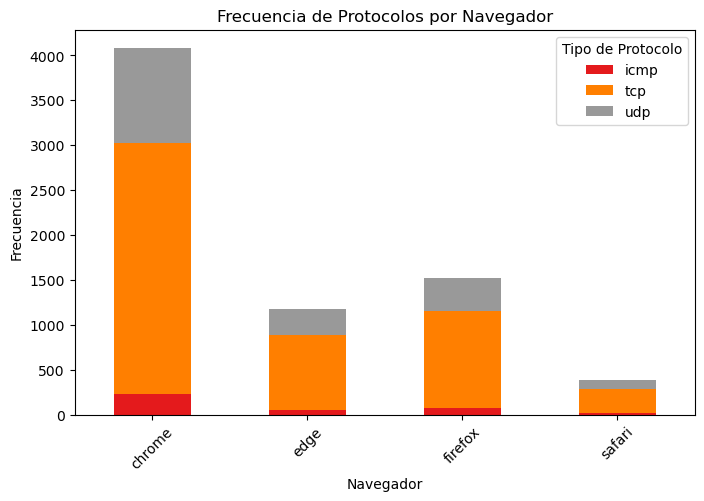

In [104]:
protocol_counts = pd.crosstab(df_normal_pic['browser_type'], df_normal_pic['protocol_type'])
protocol_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap="Set1")
plt.title("Frecuencia de Protocolos por Navegador")
plt.xlabel("Navegador")
plt.ylabel("Frecuencia")
plt.legend(title="Tipo de Protocolo")
plt.xticks(rotation=45)
plt.savefig('img/protocol_frecuency_nav.png')

### Mapa de Calor de Correlación entre Variables

Este bloque de código crea un **mapa de calor** que muestra la **correlación** entre el tiempo de duración **`session_duration`** con los paquetes que se envían durante la sesión**`network_packet_size`**, además de los ataques detectados **`attack_detected`** y la reputación de la IP **`ip_reputation_score`**.

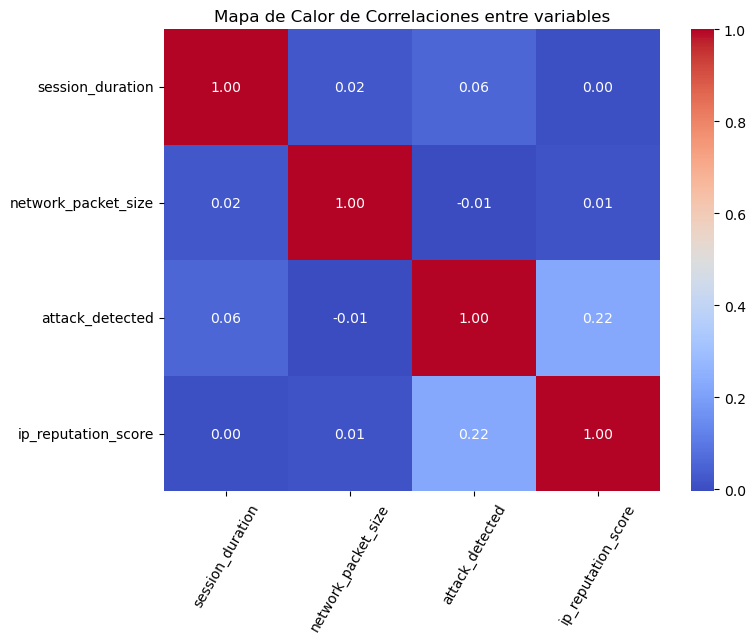

In [43]:
# Crear un DataFrame con las tres columnas que quieres analizar
df_three_vars = df_normalized[['session_duration', 'network_packet_size', 'attack_detected', 'ip_reputation_score']]

# Calcular la correlación entre las tres variables
correlation = df_three_vars.corr()

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')

# Añadir título
plt.title('Mapa de Calor de Correlaciones entre variables')
plt.xticks(rotation=60)
# Mostrar el gráfico
plt.savefig('img/map_correlation_variables.png')

### Gráfica de barras protocol_type y attack_detected

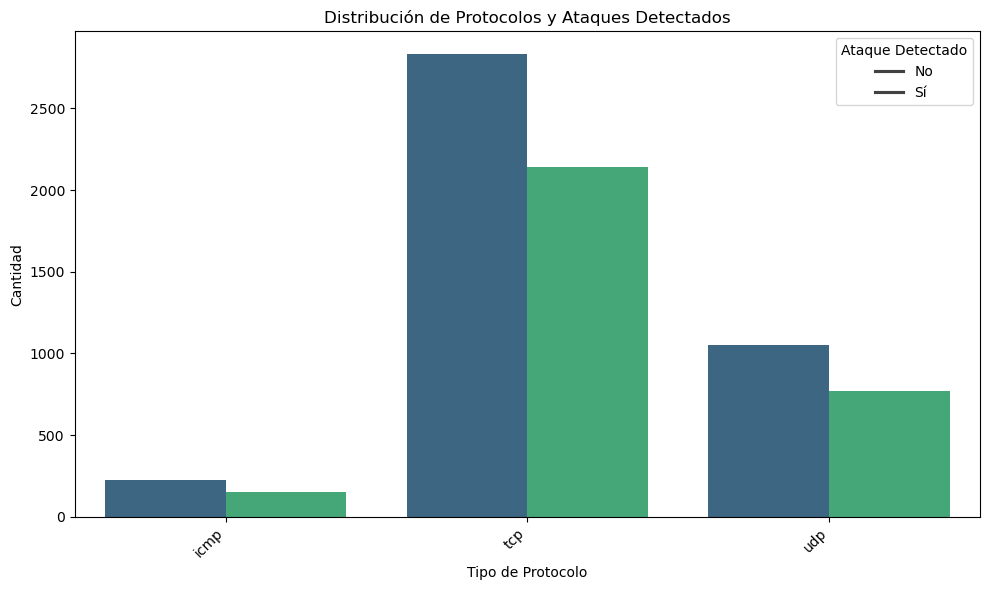

In [15]:
# Agrupar los datos por tipo de protocolo y ataque detectado
grouped_data = df_normalized.groupby(['protocol_type', 'attack_detected']).size().reset_index(name='count')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='protocol_type', y='count', hue='attack_detected', palette='viridis')

# Configurar el gráfico
plt.title('Distribución de Protocolos y Ataques Detectados')
plt.xlabel('Tipo de Protocolo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ataque Detectado', labels=['No', 'Sí'])
plt.tight_layout()
plt.show()